In [1]:
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt

import lab4_util

Проверка наличия доступа к CUDA:

In [3]:
print('CUDA is available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Number of available devices:', torch.cuda.device_count())
    print('Current device:', torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print('  ', i, ':', torch.cuda.get_device_name(0))

CUDA is available: True
Number of available devices: 1
Current device: 0
   0 : GeForce RTX 2080 SUPER


# Загрузка данных

In [4]:
# See https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
train_dataset = torchvision.datasets.ImageFolder('data/eyes/train')
val_dataset = torchvision.datasets.ImageFolder('data/eyes/val')

Некоторая статистика по наборам данных:

In [5]:
for dataset in train_dataset, val_dataset:
    print('Size:', len(dataset))
    print('Classes:', dataset.classes)

Size: 1939
Classes: ['closed', 'open']
Size: 242
Classes: ['closed', 'open']


Набор данных, реализуемый `ImageFolder`, поддерживает доступ по индексу (не все наборы данных таковы).

In [6]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=100x100 at 0x7F19663A5160>, 0)

Элемент набора данных представляет собой кортеж из двух элементов: RGB-картинка и ее метка. Картинки бывает очень полезно визуализировать:

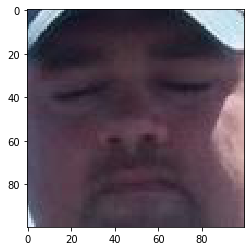

In [7]:
plt.imshow(train_dataset[0][0])

К сожалению, в таком виде (в виде объектов `PIL.Image`) данные невозможно загружать в нейронную сеть. Все модули PyTorch "хотят" работать с тензорами. Для автоматического преобразования загружаемых картинок в тензоры можно использовать свойство `transform` набора данных. Его можно задавать как при конструировании объекта (именованный параметр `transform` конструктора), так и после (это менее желательно). В библиотеке `torchvision` уже реализовано множество полезных трансформаций (см. модуль `torchvision.transforms`), нам пригодится `torchvision.transforms.ToTensor`:

In [8]:
train_dataset.transform = torchvision.transforms.ToTensor()
val_dataset.transform = torchvision.transforms.ToTensor()

In [9]:
train_dataset[0][0].shape, train_dataset[0][0]

(torch.Size([3, 100, 100]),
 tensor([[[0.2667, 0.2392, 0.2118,  ..., 0.5843, 0.7922, 0.9569],
          [0.2196, 0.2118, 0.2431,  ..., 0.5569, 0.4667, 0.5922],
          [0.1725, 0.1961, 0.2196,  ..., 0.7804, 0.6000, 0.3216],
          ...,
          [0.8549, 0.8902, 0.6431,  ..., 0.4588, 0.4863, 0.5137],
          [0.8667, 0.8863, 0.8000,  ..., 0.4627, 0.4824, 0.5020],
          [0.8784, 0.8667, 0.9020,  ..., 0.4667, 0.4784, 0.4902]],
 
         [[0.3333, 0.3059, 0.2784,  ..., 0.6235, 0.8314, 0.9961],
          [0.2863, 0.2784, 0.3098,  ..., 0.6039, 0.5137, 0.6392],
          [0.2510, 0.2745, 0.2980,  ..., 0.8353, 0.6549, 0.3765],
          ...,
          [0.9059, 0.9333, 0.6745,  ..., 0.3569, 0.3843, 0.4118],
          [0.9176, 0.9294, 0.8314,  ..., 0.3608, 0.3804, 0.4000],
          [0.9294, 0.9098, 0.9333,  ..., 0.3647, 0.3765, 0.3882]],
 
         [[0.4510, 0.4157, 0.3882,  ..., 0.6706, 0.8784, 1.0000],
          [0.4039, 0.3882, 0.4196,  ..., 0.6510, 0.5608, 0.6863],
          [0

В результате изображения не только стали тензорами, но и значения были отмасштабированы с диапазона [0-255] в [0-1], что более подходит для задачи обучения. С помощью трансформаций можно также изменять размер изображений и делать множество других преобразований, которых мы коснемся чуть позже.

Для загрузки данных в модель в ходе обучения предназначен специальный класс-загрузчик `DataLoader`. Он является оберткой над набором данных и обеспечивает разбиение на батчи, многопоточную подгрузку и еще ряд полезных функций.

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Загрузчики позволяют получить итератор по батчам. обеспечивающий идиоматическое использование:

```
for x, y in loader:
   # Обучение на одном батче
```

In [11]:
x, y = next(iter(train_loader))
print('X shape:', x.shape)
print('y shape:', y.shape)

X shape: torch.Size([32, 3, 100, 100])
y shape: torch.Size([32])


# Определение модели

In [12]:
class SimpleModel(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 10, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 1, kernel_size=1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(1),
            torch.nn.Linear(441, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
          
        )
    
    def forward(self, x):
        return self.layers(x)
        

Проверим, можно ли применить модель к батчу:

In [13]:
model = SimpleModel()
model(x)

tensor([[0.5030],
        [0.4982],
        [0.5134],
        [0.5213],
        [0.4660],
        [0.5076],
        [0.5312],
        [0.5015],
        [0.5260],
        [0.4955],
        [0.5037],
        [0.4436],
        [0.5149],
        [0.5264],
        [0.4830],
        [0.5059],
        [0.5225],
        [0.5025],
        [0.5110],
        [0.4929],
        [0.5361],
        [0.5150],
        [0.4892],
        [0.5287],
        [0.5172],
        [0.4806],
        [0.5065],
        [0.5103],
        [0.4886],
        [0.5291],
        [0.5012],
        [0.5025]], grad_fn=<SigmoidBackward>)

Организуем уже знакомый цикл обучения:

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

def train_epoch():
    total_loss = 0.0
    total_batches = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(X.to(device))
        loss = loss_fn(y_hat[:, 0], y.to(torch.float32).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().to('cpu')
        total_batches += 1
    return total_loss / total_batches

for epoch in range(5):
    train_loss = train_epoch()
    print(f'Epoch {epoch}: {train_loss}')


Epoch 0: 0.5782591104507446
Epoch 1: 0.4892529845237732
Epoch 2: 0.4521893560886383
Epoch 3: 0.39732587337493896
Epoch 4: 0.3612029552459717


Видно, что с ходом обучения значение функции потерь снижается. Это хороший знак.

В дальнейшем мы будем использовать функцию `train` из вспомогательного модуля, реализующую цикл обучения подобный приведенному выше, а также выполняющую еще ряд задач (вроде сбора значений метрик, проверки критерия ранней остановки и пр.). 

Обучим модель в течение достаточно большого числа итераций, попутно проведя оценку на валидационном множестве:

In [15]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=25)   # Ограничение на количество эпох

100%|██████████| 61/61 [00:02<00:00, 21.63it/s]


Epoch 0: train loss 0.58344
Epoch 0: val loss 0.65855


100%|██████████| 61/61 [00:02<00:00, 21.73it/s]


Epoch 1: train loss 0.43855
Epoch 1: val loss 0.50695


100%|██████████| 61/61 [00:02<00:00, 21.93it/s]


Epoch 2: train loss 0.33676
Epoch 2: val loss 0.41505


100%|██████████| 61/61 [00:02<00:00, 21.84it/s]


Epoch 3: train loss 0.25952
Epoch 3: val loss 0.45232


100%|██████████| 61/61 [00:02<00:00, 21.71it/s]


Epoch 4: train loss 0.18992
Epoch 4: val loss 0.49718


100%|██████████| 61/61 [00:02<00:00, 21.70it/s]


Epoch 5: train loss 0.14916
Epoch 5: val loss 0.73381


100%|██████████| 61/61 [00:02<00:00, 21.91it/s]


Epoch 6: train loss 0.08070
Epoch 6: val loss 0.49714


100%|██████████| 61/61 [00:02<00:00, 21.87it/s]


Epoch 7: train loss 0.06367
Epoch 7: val loss 0.49143


100%|██████████| 61/61 [00:02<00:00, 21.99it/s]


Epoch 8: train loss 0.04676
Epoch 8: val loss 0.53633


100%|██████████| 61/61 [00:02<00:00, 21.60it/s]


Epoch 9: train loss 0.02296
Epoch 9: val loss 0.66579


100%|██████████| 61/61 [00:02<00:00, 21.57it/s]


Epoch 10: train loss 0.00511
Epoch 10: val loss 0.67856


100%|██████████| 61/61 [00:02<00:00, 21.61it/s]


Epoch 11: train loss 0.00243
Epoch 11: val loss 0.69426


100%|██████████| 61/61 [00:02<00:00, 21.87it/s]


Epoch 12: train loss 0.00104
Epoch 12: val loss 0.71453


100%|██████████| 61/61 [00:02<00:00, 21.69it/s]


Epoch 13: train loss 0.00068
Epoch 13: val loss 0.72480


100%|██████████| 61/61 [00:02<00:00, 21.54it/s]


Epoch 14: train loss 0.00053
Epoch 14: val loss 0.73930


100%|██████████| 61/61 [00:02<00:00, 21.77it/s]


Epoch 15: train loss 0.00040
Epoch 15: val loss 0.74415


100%|██████████| 61/61 [00:02<00:00, 21.92it/s]


Epoch 16: train loss 0.00034
Epoch 16: val loss 0.75795


100%|██████████| 61/61 [00:02<00:00, 21.85it/s]


Epoch 17: train loss 0.00029
Epoch 17: val loss 0.77514


100%|██████████| 61/61 [00:02<00:00, 21.87it/s]


Epoch 18: train loss 0.00027
Epoch 18: val loss 0.79889


100%|██████████| 61/61 [00:02<00:00, 21.71it/s]


Epoch 19: train loss 0.00021
Epoch 19: val loss 0.78871


100%|██████████| 61/61 [00:02<00:00, 21.76it/s]


Epoch 20: train loss 0.00021
Epoch 20: val loss 0.80037


100%|██████████| 61/61 [00:02<00:00, 21.67it/s]


Epoch 21: train loss 0.00018
Epoch 21: val loss 0.81038


100%|██████████| 61/61 [00:02<00:00, 22.04it/s]


Epoch 22: train loss 0.00016
Epoch 22: val loss 0.82256


100%|██████████| 61/61 [00:02<00:00, 21.85it/s]


Epoch 23: train loss 0.00015
Epoch 23: val loss 0.82525


100%|██████████| 61/61 [00:02<00:00, 21.86it/s]


Epoch 24: train loss 0.00013
Epoch 24: val loss 0.83250


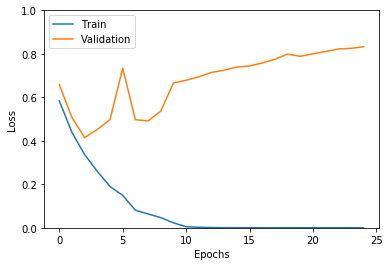

In [16]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

In [17]:
lab4_util.accuracy(model, val_loader)

0.8285156190395355

## Аугментации

In [18]:
train_dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ToTensor()
])

In [19]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=25)   # Ограничение на количество эпох

100%|██████████| 61/61 [00:02<00:00, 20.82it/s]


Epoch 0: train loss 0.61412
Epoch 0: val loss 0.54141


100%|██████████| 61/61 [00:02<00:00, 20.77it/s]


Epoch 1: train loss 0.55063
Epoch 1: val loss 0.54449


100%|██████████| 61/61 [00:02<00:00, 20.73it/s]


Epoch 2: train loss 0.51283
Epoch 2: val loss 0.49910


100%|██████████| 61/61 [00:02<00:00, 20.75it/s]


Epoch 3: train loss 0.49387
Epoch 3: val loss 0.62181


100%|██████████| 61/61 [00:02<00:00, 20.88it/s]


Epoch 4: train loss 0.48351
Epoch 4: val loss 0.54026


100%|██████████| 61/61 [00:02<00:00, 20.86it/s]


Epoch 5: train loss 0.46194
Epoch 5: val loss 0.46996


100%|██████████| 61/61 [00:02<00:00, 20.72it/s]


Epoch 6: train loss 0.45876
Epoch 6: val loss 0.53869


100%|██████████| 61/61 [00:02<00:00, 20.70it/s]


Epoch 7: train loss 0.46211
Epoch 7: val loss 0.66240


100%|██████████| 61/61 [00:02<00:00, 20.80it/s]


Epoch 8: train loss 0.46063
Epoch 8: val loss 0.69263


100%|██████████| 61/61 [00:02<00:00, 20.49it/s]


Epoch 9: train loss 0.42537
Epoch 9: val loss 0.55220


100%|██████████| 61/61 [00:03<00:00, 20.15it/s]


Epoch 10: train loss 0.41570
Epoch 10: val loss 0.70450


100%|██████████| 61/61 [00:03<00:00, 20.08it/s]


Epoch 11: train loss 0.37018
Epoch 11: val loss 0.55625


100%|██████████| 61/61 [00:02<00:00, 20.59it/s]


Epoch 12: train loss 0.34691
Epoch 12: val loss 0.50613


100%|██████████| 61/61 [00:02<00:00, 20.55it/s]


Epoch 13: train loss 0.33499
Epoch 13: val loss 0.42014


100%|██████████| 61/61 [00:02<00:00, 20.81it/s]


Epoch 14: train loss 0.32321
Epoch 14: val loss 0.35055


100%|██████████| 61/61 [00:02<00:00, 20.54it/s]


Epoch 15: train loss 0.29180
Epoch 15: val loss 0.48512


100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


Epoch 16: train loss 0.29269
Epoch 16: val loss 0.30177


100%|██████████| 61/61 [00:03<00:00, 20.19it/s]


Epoch 17: train loss 0.29600
Epoch 17: val loss 0.32318


100%|██████████| 61/61 [00:02<00:00, 20.66it/s]


Epoch 18: train loss 0.28301
Epoch 18: val loss 0.41196


100%|██████████| 61/61 [00:02<00:00, 20.80it/s]


Epoch 19: train loss 0.24873
Epoch 19: val loss 0.33016


100%|██████████| 61/61 [00:03<00:00, 19.97it/s]


Epoch 20: train loss 0.22814
Epoch 20: val loss 0.26379


100%|██████████| 61/61 [00:02<00:00, 20.63it/s]


Epoch 21: train loss 0.21748
Epoch 21: val loss 0.66377


100%|██████████| 61/61 [00:02<00:00, 20.85it/s]


Epoch 22: train loss 0.21455
Epoch 22: val loss 0.28604


100%|██████████| 61/61 [00:02<00:00, 21.22it/s]


Epoch 23: train loss 0.21811
Epoch 23: val loss 0.24549


100%|██████████| 61/61 [00:02<00:00, 21.26it/s]


Epoch 24: train loss 0.19643
Epoch 24: val loss 0.29913


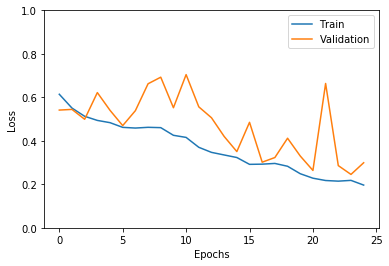

In [20]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

Видно, что:

1. Задача обучения стала "сложнее" для сети - значение функции потерь на обучающем множестве не так быстро приближается к нулю.
2. По всей видимости, сеть лучше обобщает данные - функция потерь на множестве валидации также уменьшается, не достигая так быстро плато.


In [21]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=50)   # Ограничение на количество эпох

100%|██████████| 61/61 [00:02<00:00, 21.22it/s]


Epoch 0: train loss 0.61241
Epoch 0: val loss 0.70384


100%|██████████| 61/61 [00:02<00:00, 21.20it/s]


Epoch 1: train loss 0.54526
Epoch 1: val loss 0.51750


100%|██████████| 61/61 [00:02<00:00, 20.63it/s]


Epoch 2: train loss 0.49900
Epoch 2: val loss 0.50605


100%|██████████| 61/61 [00:02<00:00, 20.41it/s]


Epoch 3: train loss 0.52487
Epoch 3: val loss 0.61787


100%|██████████| 61/61 [00:02<00:00, 20.52it/s]


Epoch 4: train loss 0.49481
Epoch 4: val loss 0.48273


100%|██████████| 61/61 [00:02<00:00, 20.86it/s]


Epoch 5: train loss 0.47835
Epoch 5: val loss 0.55761


100%|██████████| 61/61 [00:02<00:00, 20.91it/s]


Epoch 6: train loss 0.45884
Epoch 6: val loss 0.68350


100%|██████████| 61/61 [00:02<00:00, 20.89it/s]


Epoch 7: train loss 0.46618
Epoch 7: val loss 0.46033


100%|██████████| 61/61 [00:02<00:00, 20.61it/s]


Epoch 8: train loss 0.43530
Epoch 8: val loss 0.67939


100%|██████████| 61/61 [00:03<00:00, 20.31it/s]


Epoch 9: train loss 0.41622
Epoch 9: val loss 0.46102


100%|██████████| 61/61 [00:02<00:00, 20.62it/s]


Epoch 10: train loss 0.38681
Epoch 10: val loss 0.57586


100%|██████████| 61/61 [00:02<00:00, 20.46it/s]


Epoch 11: train loss 0.36506
Epoch 11: val loss 0.40765


100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


Epoch 12: train loss 0.34008
Epoch 12: val loss 0.30992


100%|██████████| 61/61 [00:02<00:00, 20.91it/s]


Epoch 13: train loss 0.29647
Epoch 13: val loss 0.29899


100%|██████████| 61/61 [00:02<00:00, 20.91it/s]


Epoch 14: train loss 0.25876
Epoch 14: val loss 0.24372


100%|██████████| 61/61 [00:02<00:00, 20.90it/s]


Epoch 15: train loss 0.25374
Epoch 15: val loss 0.27904


100%|██████████| 61/61 [00:02<00:00, 20.92it/s]


Epoch 16: train loss 0.22960
Epoch 16: val loss 0.16849


100%|██████████| 61/61 [00:02<00:00, 20.88it/s]


Epoch 17: train loss 0.19750
Epoch 17: val loss 0.24066


100%|██████████| 61/61 [00:03<00:00, 20.33it/s]


Epoch 18: train loss 0.17663
Epoch 18: val loss 0.23526


100%|██████████| 61/61 [00:02<00:00, 20.90it/s]


Epoch 19: train loss 0.16941
Epoch 19: val loss 0.14259


100%|██████████| 61/61 [00:02<00:00, 20.91it/s]


Epoch 20: train loss 0.20564
Epoch 20: val loss 0.14625


100%|██████████| 61/61 [00:02<00:00, 20.60it/s]


Epoch 21: train loss 0.15061
Epoch 21: val loss 0.14982


100%|██████████| 61/61 [00:02<00:00, 20.92it/s]


Epoch 22: train loss 0.15735
Epoch 22: val loss 0.15105


100%|██████████| 61/61 [00:02<00:00, 20.44it/s]


Epoch 23: train loss 0.12868
Epoch 23: val loss 0.13549


100%|██████████| 61/61 [00:02<00:00, 20.36it/s]


Epoch 24: train loss 0.16806
Epoch 24: val loss 0.12104


100%|██████████| 61/61 [00:02<00:00, 20.46it/s]


Epoch 25: train loss 0.12436
Epoch 25: val loss 0.11059


100%|██████████| 61/61 [00:02<00:00, 20.38it/s]


Epoch 26: train loss 0.12719
Epoch 26: val loss 0.13271


100%|██████████| 61/61 [00:02<00:00, 20.88it/s]


Epoch 27: train loss 0.11117
Epoch 27: val loss 0.07800


100%|██████████| 61/61 [00:02<00:00, 20.87it/s]


Epoch 28: train loss 0.10529
Epoch 28: val loss 0.10463


100%|██████████| 61/61 [00:02<00:00, 20.88it/s]


Epoch 29: train loss 0.11912
Epoch 29: val loss 0.19879


100%|██████████| 61/61 [00:02<00:00, 20.75it/s]


Epoch 30: train loss 0.11366
Epoch 30: val loss 0.21824


100%|██████████| 61/61 [00:02<00:00, 20.94it/s]


Epoch 31: train loss 0.09893
Epoch 31: val loss 0.09061


100%|██████████| 61/61 [00:02<00:00, 20.90it/s]


Epoch 32: train loss 0.11659
Epoch 32: val loss 0.19452


100%|██████████| 61/61 [00:02<00:00, 20.51it/s]


Epoch 33: train loss 0.09316
Epoch 33: val loss 0.07967


100%|██████████| 61/61 [00:02<00:00, 21.09it/s]


Epoch 34: train loss 0.09979
Epoch 34: val loss 0.10249


100%|██████████| 61/61 [00:02<00:00, 21.08it/s]


Epoch 35: train loss 0.08182
Epoch 35: val loss 0.11118


100%|██████████| 61/61 [00:02<00:00, 20.81it/s]


Epoch 36: train loss 0.08443
Epoch 36: val loss 0.14585


100%|██████████| 61/61 [00:02<00:00, 20.70it/s]


Epoch 37: train loss 0.10133
Epoch 37: val loss 0.10871


100%|██████████| 61/61 [00:02<00:00, 20.63it/s]


Epoch 38: train loss 0.08953
Epoch 38: val loss 0.10782


100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


Epoch 39: train loss 0.07800
Epoch 39: val loss 0.12556


100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


Epoch 40: train loss 0.08787
Epoch 40: val loss 0.13749


100%|██████████| 61/61 [00:02<00:00, 20.86it/s]


Epoch 41: train loss 0.08053
Epoch 41: val loss 0.09458


100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


Epoch 42: train loss 0.08943
Epoch 42: val loss 0.13304


100%|██████████| 61/61 [00:02<00:00, 20.89it/s]


Epoch 43: train loss 0.09168
Epoch 43: val loss 0.07199


100%|██████████| 61/61 [00:02<00:00, 20.85it/s]


Epoch 44: train loss 0.10942
Epoch 44: val loss 0.12609


100%|██████████| 61/61 [00:02<00:00, 20.70it/s]


Epoch 45: train loss 0.07922
Epoch 45: val loss 0.10965


100%|██████████| 61/61 [00:02<00:00, 20.71it/s]


Epoch 46: train loss 0.06869
Epoch 46: val loss 0.10735


100%|██████████| 61/61 [00:02<00:00, 20.58it/s]


Epoch 47: train loss 0.07147
Epoch 47: val loss 0.06227


100%|██████████| 61/61 [00:02<00:00, 20.88it/s]


Epoch 48: train loss 0.06900
Epoch 48: val loss 0.13002


100%|██████████| 61/61 [00:02<00:00, 20.95it/s]


Epoch 49: train loss 0.06286
Epoch 49: val loss 0.07905


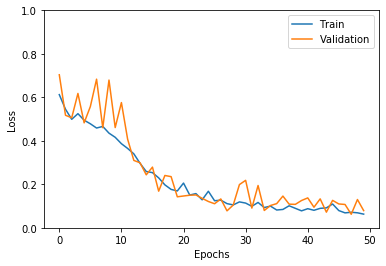

In [22]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

Оценим качество предсказаний с помощью метрики:

In [23]:
lab4_util.accuracy(model, val_loader)

0.911142572760582

# Обучение с переносом (transfer learning)


In [24]:
import torchvision.models

В модуле `torchvision.models` представлено несколько популярных нейросетевых архитектур, используемых в задачах компьютерного зрения. Их можно инициализировать случайными весами (и обучать с нуля под задачу) или же загружать веса, полученные при обучении этих моделей на наборе данных ImageNet (для этого нужно установить параметр `pretrained=True`.

In [25]:
resnet_model = torchvision.models.resnet18(pretrained=True)

С загруженной сетью нужно сделать две вещи:

1. Необходимо зафиксировать часть слоев, исключив их из процесса обучения.
2. Необходимо изменить "голову" сети - оригинальная ResNet обучена для классификации изображения на принадлежность к одному из 1000 классов, нам же нужно решать задачу бинарной классификации.


## 1. "Заморозка" весов части слоев

Параметры сети являются тензорами (`torch.tensor`), а за то, участвует ли тензор в распространении градиента ошибки, отвечает его свойство `requires_grad`. Соответственно, для исключения из обучения достаточно параметрам части слоев установить `requires_grad=False`. Для всей сети это было бы сделать довольно просто:

    for param in resnet_model.parameters():
        param.requires_grad = False

Однако если мы хотим заморозить лишь часть слоев, то необходимо понимать устройство сети и, в частности, то, из каких экземпляров `nn.Module` она состоит.


In [26]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

К компонентам модели можно обращаться с помощью атрибута, имя которого совпадает с именем блока в распечатке выше:

In [27]:
resnet_model.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

Оставим доступными для обучения только последнюю группу блоков (`layer4`). Для этого сначала "заморозим" все веса, а потом "разморозим" только `layer4`:

In [28]:
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.layer4.parameters():
    param.requires_grad = True

## 2. Замена "головы" сети

In [29]:
resnet_model.fc = torch.nn.Linear(512, 1)

# Далее, применим сигмоидальную функцию активации
# к выходу сети.
#
# Строго говоря, это делать не обязательно. В данном
# случае это делается исключительно для того, чтобы 
# обеспечить идентичность "интерфейса" "самодельной"
# сети и ResNet. Дело в том, что модель ResNet из 
# torchvision возвращает т.н. logits - просто значения,
# чем больше, тем больше вероятность соответствующего
# класса. Вывод сети в таком виде, во-первых, оказывается
# не совместим с BCELoss, во-вторых, вспомогательные
# функции из lab4_util рассчитывают на то, что
# выходом сети будет число от 0 до 1 (степень уверенности
# сети в том, что глаза на фотографии открыты)
model_2 = torch.nn.Sequential(
    resnet_model,
    torch.nn.Sigmoid()
)

In [30]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters())
history = lab4_util.train(model_2,        # Обучаемая модель
                          loss_fn,        # Функция потерь
                          optimizer,      # Оптимизатор
                          train_loader,   # Загрузчик данных обучающего множества
                          val_loader,     # Загрузчик данных множества валидации
                          max_epochs=5)   # Ограничение на количество эпох

100%|██████████| 61/61 [00:01<00:00, 39.12it/s]


Epoch 0: train loss 0.31313
Epoch 0: val loss 0.10576


100%|██████████| 61/61 [00:01<00:00, 41.13it/s]


Epoch 1: train loss 0.16423
Epoch 1: val loss 0.09874


100%|██████████| 61/61 [00:01<00:00, 39.48it/s]


Epoch 2: train loss 0.12762
Epoch 2: val loss 0.09074


100%|██████████| 61/61 [00:01<00:00, 39.99it/s]


Epoch 3: train loss 0.12649
Epoch 3: val loss 0.12864


100%|██████████| 61/61 [00:01<00:00, 40.96it/s]


Epoch 4: train loss 0.10647
Epoch 4: val loss 0.08182


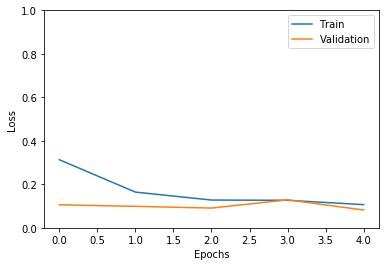

In [31]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

In [32]:
lab4_util.accuracy(model_2, val_loader)

0.911142572760582